In [4]:
import os
import numpy as np
import torch
import cv2
import manga109api
import matplotlib.pyplot as plt
from src.model import EfficientDet
from tqdm.notebook import tqdm
import easyocr

In [5]:
PATH = "mangadet.pth"

In [6]:
model = EfficientDet(num_classes = 2).cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientDet(
  (conv3): Conv2d(40, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(192, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (2): BatchNorm2d(64, eps=4e-05, momentum=0.9997, affine=True, track_running_stats=True)
          (3): ReLU()
        )
      )
      (conv5_up): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
          (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
 

In [7]:
image_base_path = "F:\\Datasets\\Manga109\\images\\"
manga109_root_dir = "F:\\Datasets\\Manga109"
p = manga109api.Parser(root_dir=manga109_root_dir)
book = "ARMS"
page_index = 19

In [8]:
IMAGE_PATH = p.img_path(book=book, index=page_index)
reader = easyocr.Reader(['ja'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [9]:
result = reader.readtext(IMAGE_PATH,paragraph="False")
result

[[[[1486, 172], [1510, 172], [1510, 214], [1486, 214]], '変'],
 [[[926, 464], [1018, 464], [1018, 579], [926, 579]], 'な見こそ いた よか 宮 亨 ん て'],
 [[[1294, 470], [1423, 470], [1423, 541], [1294, 541]],
  'なね見な死お えせんぬれ かたて きが _'],
 [[[1495, 471], [1539, 471], [1539, 543], [1495, 543]], "なな '"],
 [[[309, 593], [347, 593], [347, 629], [309, 629]], '苫挙'],
 [[[113, 659], [151, 659], [151, 725], [113, 725]], '薫'],
 [[[968, 738], [1166, 738], [1166, 808], [968, 808]], '韓韓 敵 {さ大ん ザス い'],
 [[[1243, 729], [1320, 729], [1320, 837], [1243, 837]], '製髪 舞ドえ ねど  号'],
 [[[1367, 727], [1405, 727], [1405, 777], [1367, 777]], '艶'],
 [[[687, 741], [723, 741], [723, 805], [687, 805]], 'さ 馨'],
 [[[308, 856], [366, 856], [366, 921], [308, 921]], 'ま波艶 かに体 芳'],
 [[[77, 867], [151, 867], [151, 945], [77, 945]], 'ダ 薮  デ'],
 [[[507, 861], [561, 861], [561, 907], [507, 907]], ' #'],
 [[[665, 865], [721, 865], [721, 941], [665, 941]], '"  #'],
 [[[70, 1096], [682, 1096], [682, 1158], [70, 1158]],
  '超子弾ニレイルガンで射ち出す弾体の モノポール

In [12]:
img = cv2.imread(IMAGE_PATH)
width, height, _ = img.shape
h_scale, w_scale = width/512, height/512
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
img = img.astype(np.float32) / 255.
img = torch.from_numpy(img).unsqueeze(0)
img = img.permute(0, 3, 1, 2).double().cuda()

In [11]:
with torch.no_grad():
    out = model(img)

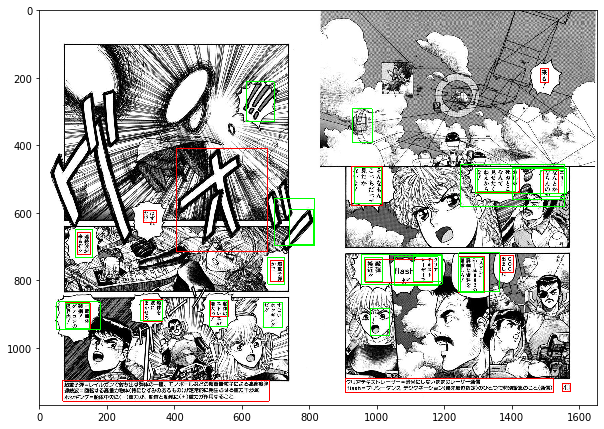

In [17]:
img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for box in result:
    start_point = box[0][0]
    end_point = box[0][2]
    color = (255, 0, 0)
    thickness = 2
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
    

for score, co in zip(out[0], out[2]):
    if score < 0.1:
        continue
    color = (0, 255, 0)
    thickness = 2
    start_point = (int(co[0] * w_scale) , int(co[1] * h_scale))
    end_point = (int(co[2] * w_scale), int(co[3] * h_scale))
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.figure(figsize=(10,12)) 
plt.imshow(img)

In [18]:
cv2.imwrite("easyocr + efficientdet.png", img)

True